In [556]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve

Define the function to compute the kernel given the weights and the degree of the polynomial

In [557]:
def compute_LPA_kernel(w, N):
    # compute the LPA kernel for a given weights and polynomial degree
    # input:
    #   w: vector containing the weights for the local LS problem
    #   N: degree of the polynomial approximation
    # return:
    #   g: the computed LPA kernel

    M = w.size

    # Define the matrix T containing the polynomials sampled over the window
    t = np.arange(1,M+1)
    T = np.ones((M,N+1))
    T[:,1] = t
    for i in range(2,N+1):
      T[:,i] = T[:,i-1] * t

    # generate the inverse of weights
    # set to zero weights that are inf
    winv = np.zeros(w.size)
    for i in range(w.size):
      if(w[i] != 0):
        winv[i] = 1/w[i]

    # define the weight matrix
    W = np.diag(w)
    Winv = np.diag(winv)

    # comput the qr decomposition of WT
    # since T has more rows than columns, then qr computes only the first N + 1 columns of Q and the first N + 1 rows of R.
    Q, R = np.linalg.qr(W @ T, mode="reduced")

    #  define Qtilde
    Qtilde =  Winv @ Q

    # adjust Qtilde with the  weights matrix squared.
    W2Qtilde = W**2 @ Qtilde

    # select the central row of W2Qtilde
    row = Qtilde[Qtilde.shape[0]//2]

    # compute the kernel
    g = W2Qtilde @ row

    # flipping, since it is used in convolution
    g = np.flip(g)

    return g


LPA-ICI
-------
Set the LPA-ICI parameters

In [558]:
# maximum degree of polynomial used for fitting
N = 5

# parameter for the confidence intervals in the ICI rule
Gamma = 2

# Set all the scale values
hmax = 51
all_h = np.arange(1, hmax+1)

Generate the signal

Text(0.5, 1.0, 'Input Signal')

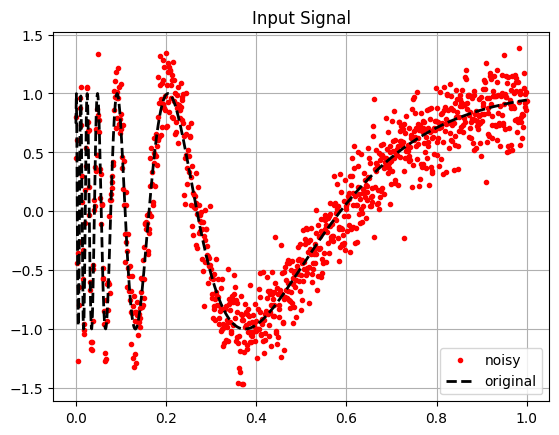

In [559]:
LENGTH = 1000

ty = np.linspace(0, 1, LENGTH)
y = np.sin(2 / (ty + 0.05))

#  noise standard deviation
sigma = 0.2

# noisy signal
s = y + sigma*np.random.normal(size=LENGTH)


plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal')

Generate the LPA kernels for all the scale. Use centered weights.


In [560]:
all_g = []
for i in range(len(all_h)):
    # define the weights for the scale h (symmetric, left or right)
    M = 3 + i * 2
    w = np.ones(M) # symmetric
    #w[M//2+1:] = 0 # left
    #w[0:M//2] = 0 # right

    # compute and store the kernel g
    # TODO: implement the function compute_LPA_kernel
    g = compute_LPA_kernel(w, N)

    all_g.append(g)

Initialize all the variables for the ICI rule

In [561]:
# initialize the estimate for each scale
all_yhat = np.zeros((hmax,LENGTH))

# initialize the vector containing the best scale for each sample
best_scale = np.zeros(LENGTH)

# initialize the lower and upper bound vectors
upper_bounds = np.inf * np.ones(LENGTH)
lower_bounds = -(np.inf) * np.ones(LENGTH)

Loop over all the scales

In [562]:
for i, h in enumerate(all_h):
    g = all_g[i]

    # compute the estimate for the scale h
    yhat = np.convolve(s, g, mode='same')

    # store the computed estimate
    all_yhat[i,:] = yhat

    # compute the lower and upper bound of the confidence interval for the scale h
    lb = yhat - Gamma * sigma * np.linalg.norm(g, ord=2)
    ub = yhat + Gamma * sigma * np.linalg.norm(g, ord=2)

    # update the lower and upper bounds
    lower_bounds = np.maximum(lower_bounds, lb)
    upper_bounds = np.minimum(upper_bounds, ub)

    # identify for which samples h is the best scale according to the
    # ICI rule and update the best_scale vector accordingly
    for j in range(LENGTH):
      if (lower_bounds[j] < upper_bounds[j]):
        best_scale[j] = h - 1

Use the best scale for each sample to compute the final estimates



In [563]:
yhat_final = np.zeros(LENGTH)
for i in range(LENGTH):
    best_h = int(best_scale[i])
    yhat_final[i] = all_yhat[best_h, i]

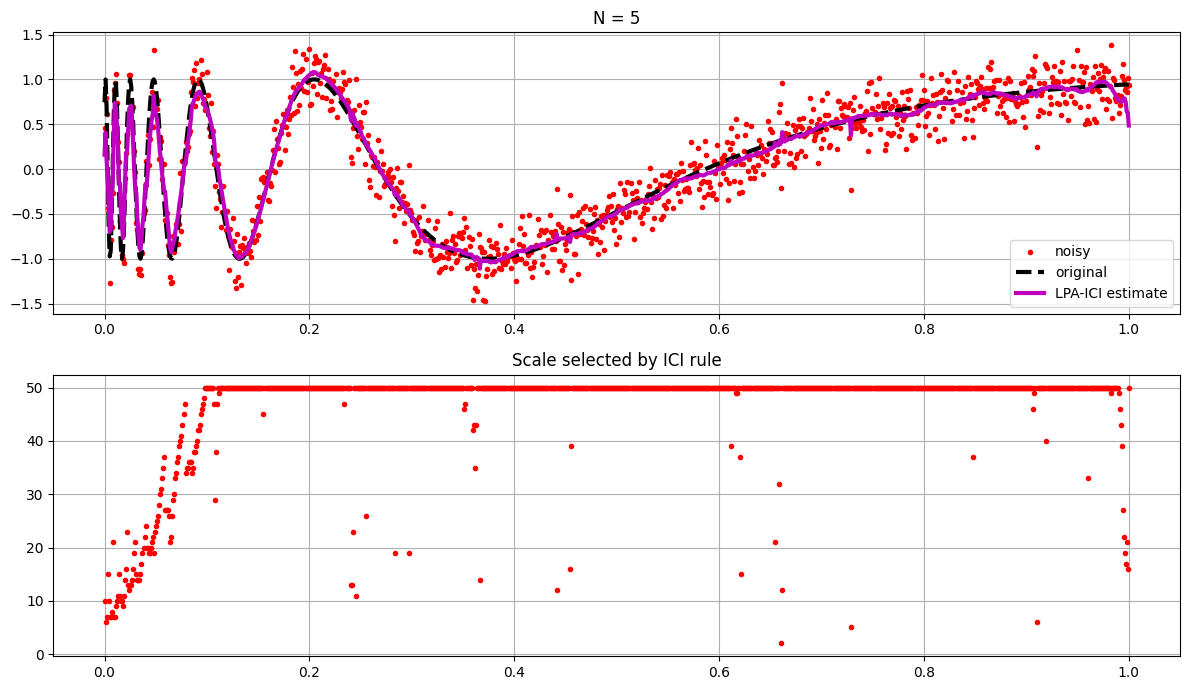

In [564]:
fig, ax = plt.subplots(2, 1, figsize = (12,7))
ax[0].plot(ty, s, 'r.')
ax[0].plot(ty, y, 'k--', linewidth=3)
ax[0].plot(ty, yhat_final, 'm-', linewidth=3)
ax[0].grid()
ax[0].legend(['noisy', 'original', 'LPA-ICI estimate'])
ax[0].set_title(f'N = {N:d}')

ax[1].plot(ty, best_scale, 'r.')
ax[1].set_title('Scale selected by ICI rule')
ax[1].grid()

fig.tight_layout()
plt.show()

LPA-ICI with Aggregation
------------------------
Set the parameters


In [565]:
# maximum degree of polynomial used for fitting
N = 1

# parameter for the confidence intervals in the ICI rule
Gamma = 2

# Set all the scale values
hmax = 51
all_h = np.arange(1, hmax+1)

Generate synthetic signal signal

Text(0.5, 1.0, 'Input Signal')

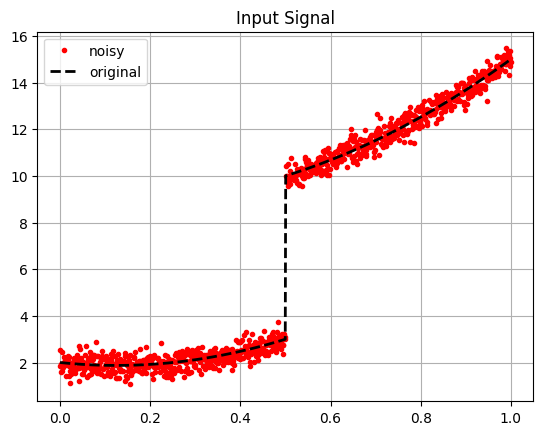

In [566]:
LENGTH = 1000
ty = np.linspace(0, 1, LENGTH)
y = 8 * ty ** 2 - 2*ty + 2
y[ty >0.5] = y[ty >0.5] + 7

#  noise standard deviation
sigma = 0.3

# noisy signal
s = y + sigma*np.random.normal(size=LENGTH)


plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal')

Generate the LPA kernels for all the scale for both left and right windows

In [567]:
all_g_left = []
all_g_right = []

for i, h in enumerate(all_h):
    M = 3 + i * 2

    # define the weights for the scale h (left)
    w = np.ones(M)
    w[M//2+1:] = 0
    g_left = compute_LPA_kernel(w, N)
    all_g_left.append(g_left)

    # define the weights for the scale h (right)
    w = np.ones(M)
    w[0:M//2] = 0
    g_right = compute_LPA_kernel(w, N)
    all_g_right.append(g_right)

Use the LPA-ICI to compute the estimate based on the **left** kernels

In [568]:
# initialize the estimate for each scale
all_yhat = np.zeros((hmax,LENGTH))

# initialize the vector containing the best scale for each sample
best_scale_left = np.zeros(LENGTH)

# initialize the lower and upper bound vectors
upper_bounds = np.inf * np.ones(LENGTH)
lower_bounds = -(np.inf) * np.ones(LENGTH)

for i, h in enumerate(all_h):
    g = all_g_left[i]

    # compute the estimate for the scale h
    yhat = np.convolve(s, g, mode='same')

    # store the computed estimate
    all_yhat[i,:] = yhat

    # compute the lower and upper bound of the confidence interval for the scale h
    lb = yhat - Gamma * sigma * np.linalg.norm(g, ord=2)
    ub = yhat + Gamma * sigma * np.linalg.norm(g, ord=2)

    # update the lower and upper bounds
    lower_bounds = np.maximum(lower_bounds, lb)
    upper_bounds = np.minimum(upper_bounds, ub)

    # identify for which samples h is the best scale according to the
    # ICI rule and update the best_scale vector accordingly
    for j in range(LENGTH):
      if (lower_bounds[j] < upper_bounds[j]):
        best_scale_left[j] = h - 1

yhat_left = np.zeros(LENGTH)
for i in range(LENGTH):
    best_h = int(best_scale_left[i])
    yhat_left[i] = all_yhat[best_h, i]

Use the LPA-ICI to compute the estimate based on the **right** kernels

In [569]:
# initialize the estimate for each scale
all_yhat = np.zeros((hmax,LENGTH))

# initialize the vector containing the best scale for each sample
best_scale_right = np.zeros(LENGTH)

# initialize the lower and upper bound vectors
upper_bounds = np.inf * np.ones(LENGTH)
lower_bounds = -(np.inf) * np.ones(LENGTH)

for i, h in enumerate(all_h):
    g = all_g_right[i]

    # compute the estimate for the scale h
    yhat = np.convolve(s, g, mode='same')

    # store the computed estimate
    all_yhat[i,:] = yhat

    # compute the lower and upper bound of the confidence interval for the scale h
    lb = yhat - Gamma * sigma * np.linalg.norm(g, ord=2)
    ub = yhat + Gamma * sigma * np.linalg.norm(g, ord=2)

    # update the lower and upper bounds
    lower_bounds = np.maximum(lower_bounds, lb)
    upper_bounds = np.minimum(upper_bounds, ub)

    # identify for which samples h is the best scale according to the
    # ICI rule and update the best_scale vector accordingly
    for j in range(LENGTH):
      if (lower_bounds[j] < upper_bounds[j]):
        best_scale_right[j] = h - 1

yhat_right = np.zeros(LENGTH)
for i in range(LENGTH):
    best_h = int(best_scale_right[i])
    yhat_right[i] = all_yhat[best_h, i]

Compute the variances of each sample of both left and right estimates

In [570]:
var_left = np.zeros(LENGTH)
var_right = np.zeros(LENGTH)
for n in range(LENGTH):
    # compute the estimates of the variances for sample n (use the
    # best_scale_left and best_scale_right vectors)
    best_h_right = int(best_scale_right[n])
    g = all_g_right[best_h_right]
    var_right[n] = sigma**2 * np.linalg.norm(g, ord=2)**2

    best_h_left = int(best_scale_left[n])
    g = all_g_left[best_h_left]
    var_left[n]= sigma**2 * np.linalg.norm(g, ord=2)**2

Perform the aggregation


In [571]:
yhat_aggr = np.zeros(LENGTH)
for i in range(LENGTH):
  w_right = 1/var_right[i]
  w_left = 1/var_left[i]
  yhat_aggr[i] = (w_right * yhat_right[i] + w_left * yhat_left[i]) / (w_right + w_left)

Text(0.5, 1.0, 'N = 1')

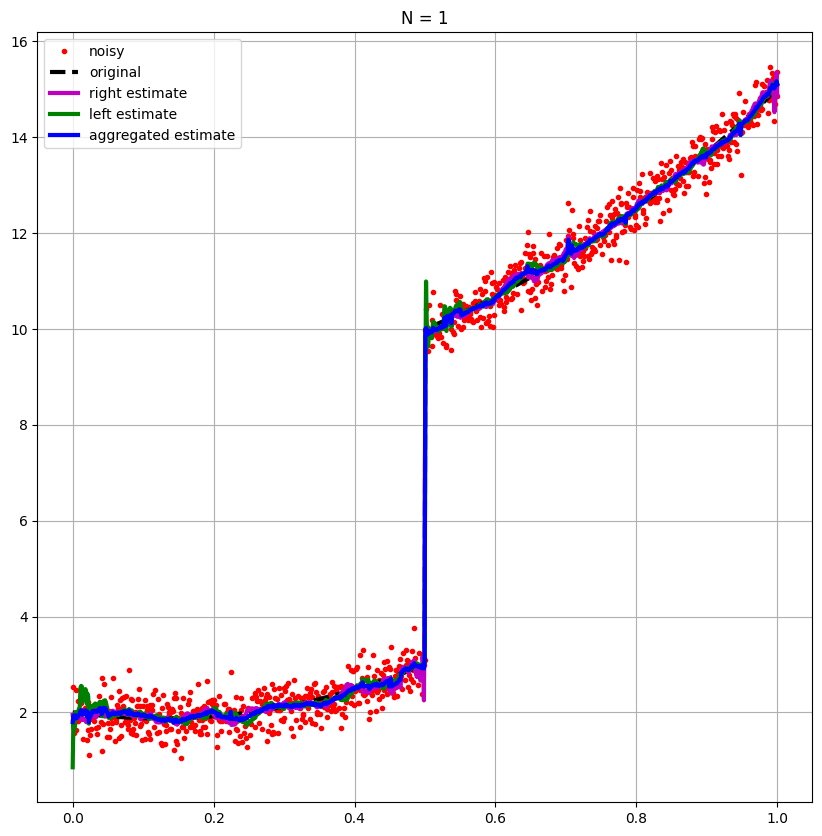

In [572]:
plt.figure(figsize=(10,10))
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=3)
plt.plot(ty, yhat_right, 'm-', linewidth=3)
plt.plot(ty, yhat_left, 'g-', linewidth=3)
plt.plot(ty, yhat_aggr, 'b-', linewidth=3)
plt.grid()
plt.legend(['noisy', 'original', 'right estimate', 'left estimate', 'aggregated estimate'])
plt.title(f'N = {N:d}')
